# Building earthquake potential suitablity layers for GRIDCERF


The following code was used to build the earhquake potential suitability layer for GRIDCERF. GRIDCERF does not provide the source data directly due to some license restrictions related for direct redistribution of the unaltered source data.  However, the following details the provenance associated with each source dataset and how they were processed.


## 1. Setup environment

### 1.1 Download GRIDCERF


Download the GRIDCERF package if you have not yet done so from here: https://doi.org/10.57931/2281697. Please extract GRIDCERF inside the data directory of this repository as the paths in this notebook are set to that expectation.


### 1.2 Import necessary Python packages

In [1]:
import os
import glob
import shutil
import tempfile

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.mask
from rasterio import features
import shapely.speedups


## 2. Configuration


In [2]:
# get the parent directory path to where this notebook is currently stored
root_dir = os.path.dirname(os.getcwd())

# data directory in repository
data_dir = os.path.join(root_dir, "data")

# GRIDCERF data directory from downloaded archive
gridcerf_dir = os.path.join(data_dir, "gridcerf")

# GRIDCERF reference data directory
reference_dir = os.path.join(gridcerf_dir, "reference")

# GRIDCERF technology specific data directory
output_dir = os.path.join(gridcerf_dir, "technology_specific")

# GRIDCERF source data directory
source_dir = os.path.join(gridcerf_dir, "source", "technology_specific")

# template siting mask raster
template_raster = os.path.join(reference_dir, "gridcerf_sitingmask.tif")

# earthquake potential data
input_file = os.path.join(source_dir, "usgs_earthquake-potential", "uspga250poly.shp")


## 3. Generate suitability raster

### 3.1 Functions to build suitability

In [3]:
def vector_to_raster(template_raster: str, 
                     gdf: gpd.GeoDataFrame, 
                     value_field: str, 
                     output_raster: str,
                     all_touched: bool = True):
    """Convert a vector layer to a raster in the GRIDCERF format.
    
    :param template_raster:         Full path with file name and extension to the input template 
                                    raster using the GRIDCERF format.
    :type template_raster:          str 
    
    :param gdf:                     Geodataframe for the vector data.
    :type gdf:                      gpd.GeoDataFrame
    
    :param value_field:             Field to use to burn raster value in.
    :type value_field:              str
    
    :param output_raster:           Full path with output name and extension for the output raster.
    :type output_raster:            str
    
    :param all_touched:             If True, all pixels touched by geometries will be burned in. 
                                    If false, only pixels whose center is within the polygon or that 
                                    are selected by Bresenham’s line algorithm will be burned in.
    :type all_touched:              bool
    """
                     
    # open the template raster and extract metadata and land mask
    with rasterio.open(template_raster) as template:

        metadata = template.meta.copy()

        # update raster data type
        metadata.update(dtype=np.int16)

        # extract land mask
        land_mask = template.read(1)
        land_mask = np.where(land_mask == 0, np.nan, 1)

        # write output raster
        with rasterio.open(output_raster, 'w+', **metadata) as out:

            out_arr = out.read(1)

            # build shapes to rasterize from target geometry and field
            shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[value_field]))

            # burn features
            burned = features.rasterize(shapes=shapes, 
                                        fill=0, 
                                        out=out_arr, 
                                        transform=out.transform,
                                        all_touched=all_touched)
            
            burned = np.where(burned == 1, 1, 0).astype(np.float64)
            
            # apply land mask
            burned *= land_mask
            
            # make nan excluded
            burned = np.where(np.isnan(burned), 1, burned)

            out.write_band(1, burned.astype(np.int16))


### 3.2 Set standard raster template

In [4]:
# open the template raster and extract metadata and land mask
with rasterio.open(template_raster) as template:

    metadata = template.meta.copy()

    # update raster data type
    metadata.update(dtype=np.float64)

    # extract land mask
    land_mask = template.read(1)
    land_mask = np.where(land_mask == 0, np.nan, 1)

    # get the template CRS
    template_crs = template.crs
        

### 3.3 Process suitability layer

#### gridcerf_usgs_earthquake_pga_0.3_at_2pct_in_50yrs_conus.tif

- **Title**:  National Seismic Hazard Model
- **Description from Source**:  Seismicity catalogs, GIS shapefiles, gridded seismic hazard curve data, gridded ground motion data, and mapped gridded ground motion values are available for the 2014 National Seismic Hazard Model for the Conterminous U.S. Probabilistic seismic hazard data and maps of the conterminous U.S. for peak ground acceleration (PGA) and 0.2 and 1.0 second spectral acceleration at probability levels of 2 percent in 50 years (annual probability of 0.000404) and 10 percent in 50 years (annual probability of 0.0021), assuming firm rock soil conditions at 760 m/s, are available. Hazard was calculated on a 0.05 degree by 0.05 degree grid, defined by a bounding box encompassing the conterminous U.S. (-125 to -65 degrees longitude west, 24.6 to 50 degrees latitude north). Development of the 2014 National Seismic Hazard Model for the Conterminous U.S. is documented in the USGS Open-File Report 2014-1091 (https://pubs.usgs.gov/of/2014/1091/). This dataset is considered a legacy dataset. The original dataset was uploaded to the USGS website at the time of publication of the seismic hazard model (2014) but was later moved over the the USGS ScienceBase Catalog (2019). The original dataset was assumed to be complete and accurate, but may contain inconsistencies when compared to more recent, actively maintained datasets. NOTE: In 2018, additional period and site class maps were calculated for the 2014 NSHM. For additional period and site class maps and data, please see https://doi.org/10.5066/P9I6BPX5, documented in USGS Open-File Report 2018-1111 (https://doi.org/10.3133/ofr20181111).
- **Source URL**:  https://www.sciencebase.gov/catalog/item/5db9be62e4b06957974eb5ca
- **Date Accessed**:  8/3/23
- **Citation**
> Shumway, A.M., 2019, Data Release for the 2014 National Seismic Hazard Model for the Conterminous U.S.: U.S. Geological Survey data release, https://doi.org/10.5066/P9P77LGZ


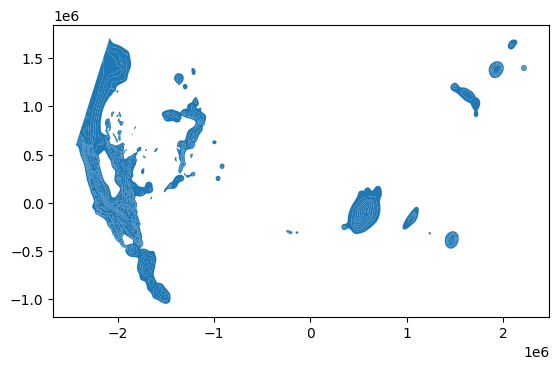

In [5]:
# read in shapefile
gdf = gpd.read_file(input_file)

# reproject to GRIDCERF 
gdf = gdf.to_crs(template_crs)

# select only >= 0.3 peak ground accelleration (pga)
gdf = gdf.loc[gdf["ACC_VAL"] >= 30].copy()

# assign raster value field
gdf["rval"] = 1

gdf.plot()

# output raster name
output_raster = os.path.join(output_dir, "gridcerf_usgs_earthquake_pga_0.3_at_2pct_in_50yrs_conus.tif")

# rasterize 
vector_to_raster(template_raster, 
                 gdf, 
                 value_field="rval", 
                 output_raster=output_raster,
                 all_touched=True)
